We trained n2v using objective functions with custom distance metrics with and without a spherical manifold, to find out where does the information in the embeddings lie. The way we tested it was by looking at its performance on a downstream task like community detection to see how well it performs. However, we were expecting the kmeans running on node2vec-dot and n2v-cosine to yield identical results because we had the constrain of the spherical manifold, however due to algorithmic implementation differences or what, they did not come out to be the same. So now, we want another way to get evidence of where is the information encoded in n2v? To nail down what info live in embedding, we ned metric-agnostic or metric-controlled tests.

Since we forced every embedding onto the unit sphere, in theory all three pairwise distances - euclid, cosine, dot are monotonic transforms of one another. 
We had already looked at the distribution of distances of embeddings between community and same communities, if I plot the ROC/AUC curves directly on those scores, if dot and euclid are truly equivalent on the sphere, i should get identical histograms (upto a linear rescaling). (Note that if we are doing this instead of ROC/AUC curves of community detection performance, so this is in some sense, more direct)

In [40]:
#TEST
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import roc_auc_score

def load_embeddings(pkl_path):
    """Load your three embedding matrices from the pickle."""
    with open(pkl_path, 'rb') as f:
        d = pickle.load(f)
    # Expect keys "dot", "euclidean", "cosine"
    return d['dot'], d['euclidean'], d['cosine']

def load_communities(csv_path):
    """Load your node→community mapping (must be a DataFrame with 'node','community')."""
    df = pd.read_csv(csv_path)
    # Assumes df.node is 0..N-1
    return df['community_id'].values

def sample_pairs(comm, n_pos=50_000, n_neg=50_000, seed=0):
    """Randomly sample n_pos same-community and n_neg different-community pairs."""
    rng = np.random.default_rng(seed)
    N = len(comm)
    same, diff = [], []
    # keep drawing until we have enough
    while len(same) < n_pos or len(diff) < n_neg:
        i, j = rng.integers(0, N, 2)
        if i == j:
            continue
        if comm[i] == comm[j]:
            if len(same) < n_pos:
                same.append((i, j))
        else:
            if len(diff) < n_neg:
                diff.append((i, j))
    pairs = np.array(same + diff, dtype=int)
    labels = np.array([1]*len(same) + [0]*len(diff))
    return pairs, labels

def compute_scores(E_dot, E_euc, E_cos, pairs):
    """Compute four score arrays for all given pairs."""
    i_idx = pairs[:,0]
    j_idx = pairs[:,1]

    # Raw dot
    scores_dot = np.sum(E_dot[i_idx]*E_dot[j_idx], axis=1)

    # Cosine: embeddings may not be normalized
    # compute norms
    norms_dot = np.linalg.norm(E_dot, axis=1)
    scores_cos = (scores_dot / 
                  (norms_dot[i_idx] * norms_dot[j_idx] + 1e-12))

    # Norm-only: negative absolute difference of norms
    scores_norm = -np.abs(norms_dot[i_idx] - norms_dot[j_idx])

    # Normalized-Euclid: unit-normalize E_dot then negative L2
    E_norm = E_dot / (norms_dot[:,None] + 1e-12)
    diffs = E_norm[i_idx] - E_norm[j_idx]
    scores_euc_norm = -np.linalg.norm(diffs, axis=1)

    return {
        'dot': scores_dot,
        'cosine': scores_cos,
        'norm_diff': scores_norm,
        'euc_on_norm': scores_euc_norm
    }

import pickle
import pandas as pd
mu = 0.3

base = "/l/research/gogandhi.NOBACKUP/alt_means_sans_k/data/experiment_n2v_metric_change_10000_50_3.0_minc50_immutable/"
file_path = f"Run_1/embeddings_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu}_k_50_mincomm_50.pkl"
comm_path = f"Run_1/community_table_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu}_k_50_mincomm_50.csv"
net_path=f"Run_1/net_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu}_k_50_mincomm_50.npz"


# 1) Load
E_dot, E_euc, E_cos = load_embeddings(base+file_path)
comm = load_communities(base+comm_path)

# 2) Sample
pairs, labels = sample_pairs(comm)

# 3) Compute
scores = compute_scores(E_dot, E_euc, E_cos, pairs)

# 4) AUC
for name, sc in scores.items():
    auc = roc_auc_score(labels, sc)
    print(f"AUC ({name:10s}): {auc:.4f}")

AUC (dot       ): 0.9998
AUC (cosine    ): 1.0000
AUC (norm_diff ): 0.8201
AUC (euc_on_norm): 1.0000


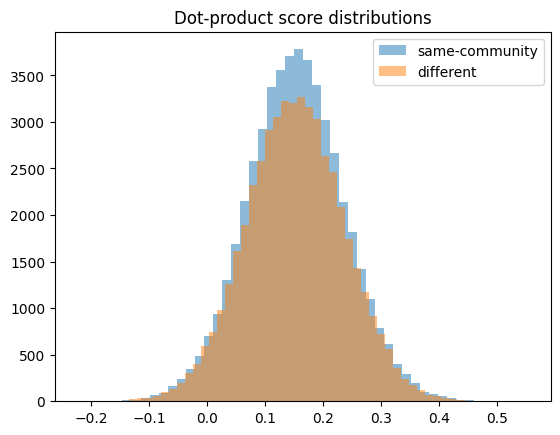

Processing k=50: 100%|████████████████████████████████████████████████████████████████████████| 200/200 [01:14<00:00,  2.68it/s]


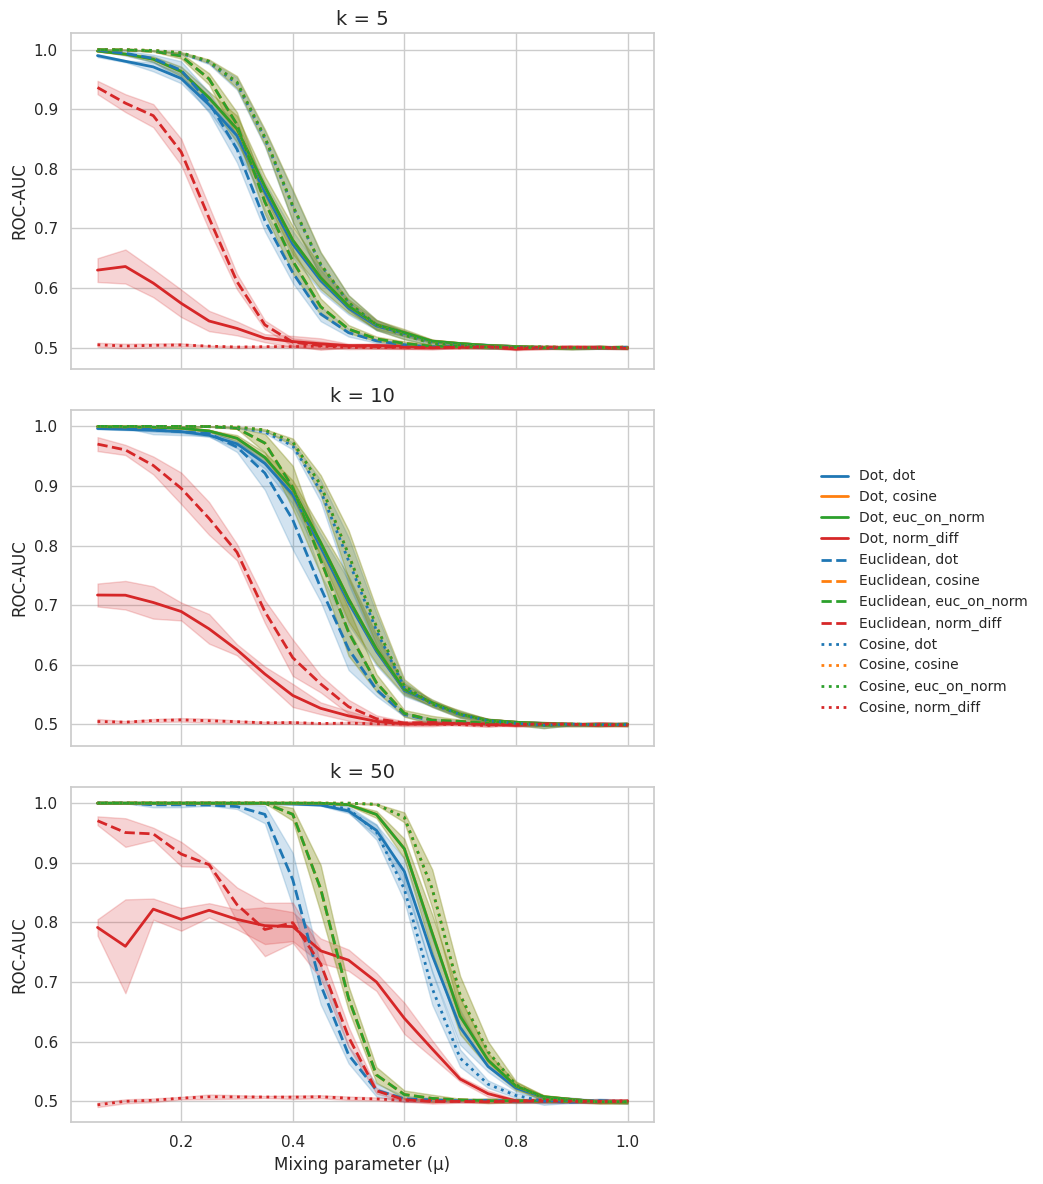

In [110]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import roc_auc_score
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# --- Helper functions ---

def sample_pairs(comm, n_pos=50000, n_neg=50000, seed=0):
    """Uniformly sample n_pos same-community and n_neg different-community pairs."""
    rng = np.random.default_rng(seed)
    N = len(comm)
    same, diff = [], []
    while len(same) < n_pos or len(diff) < n_neg:
        i, j = rng.integers(0, N, 2)
        if i == j: 
            continue
        if comm[i] == comm[j]:
            if len(same) < n_pos: same.append((i, j))
        else:
            if len(diff) < n_neg: diff.append((i, j))
    pairs = np.array(same + diff, dtype=int)
    labels = np.array([1]*len(same) + [0]*len(diff))
    return pairs, labels

def compute_scores_for_embedding(E, pairs):
    """Compute dot, cosine, norm_diff, and euc_on_norm for each pair."""
    i_idx, j_idx = pairs[:,0], pairs[:,1]
    dots = np.sum(E[i_idx] * E[j_idx], axis=1)
    norms = np.linalg.norm(E, axis=1)
    cosines = dots / (norms[i_idx] * norms[j_idx] + 1e-12)
    norm_diff = -np.abs(norms[i_idx] - norms[j_idx])
    E_unit = E / (norms[:, None] + 1e-12)
    euc_on_norm = -np.linalg.norm(E_unit[i_idx] - E_unit[j_idx], axis=1)
    return {'dot': dots, 'cosine': cosines, 'norm_diff': norm_diff, 'euc_on_norm': euc_on_norm}

def process_task(task):
    """Load embeddings and communities, sample pairs, compute AUC records."""
    mu, run, base_dir, k = task
    mu_str = f"{mu}"
    run_dir = os.path.join(base_dir, f"Run_{run}")
    emb_path = os.path.join(
        run_dir,
        f"embeddings_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu_str}_k_{k}_mincomm_50.pkl"
    )
    comm_path = os.path.join(
        run_dir,
        f"community_table_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu_str}_k_{k}_mincomm_50.csv"
    )
    # Load
    with open(emb_path, 'rb') as f:
        embeddings = pickle.load(f)
    comm = pd.read_csv(comm_path)['community_id'].values
    
    # Sample & score
    pairs, labels = sample_pairs(comm, seed=run)
    records = []
    for emb_name, E in embeddings.items():
        scores = compute_scores_for_embedding(E, pairs)
        for metric, sc in scores.items():
            auc = roc_auc_score(labels, sc)
            records.append({
                'k': k, 'mu': mu, 'run': run,
                'trained_on': emb_name,
                'eval_metric': metric,
                'auc': auc
            })
    return records

# --- Main processing loop over k values ---

mix_vals = [round(x, 2) for x in np.arange(0.05, 1.01, 0.05)]
runs = range(1, 11)
ks = [5, 10, 50]
max_workers = 32

all_records = []
for k in ks:
    base_dir = f'/l/research/gogandhi.NOBACKUP/alt_means_sans_k/data/experiment_n2v_metric_change_10000_{k}_3.0_minc50_immutable'
    tasks = [(mu, run, base_dir, k) for mu in mix_vals for run in runs]
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_task, t): t for t in tasks}
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing k={k}"):
            all_records.extend(future.result())

# --- Aggregate into dfs dict ---

df_all = pd.DataFrame(all_records)
dfs = {}
for k, grp in df_all.groupby('k'):
    agg = (
        grp.groupby(['mu', 'trained_on', 'eval_metric'])['auc']
           .agg(['mean', 'std'])
           .reset_index()
    )
    dfs[k] = agg

# --- Plotting ---

sns.set(style='whitegrid')
palette = sns.color_palette("tab10", n_colors=4)
metric_colors = {'dot': palette[0], 'cosine': palette[1],
                 'euc_on_norm': palette[2], 'norm_diff': palette[3]}
trained_styles = {'dot': 'solid', 'euclidean': 'dashed', 'cosine': 'dotted'}

fig, axes = plt.subplots(len(ks), 1, figsize=(8, 4*len(ks)), sharex=True, sharey=True)
for ax, k in zip(axes, ks):
    agg = dfs[k]
    for emb in ['dot', 'euclidean', 'cosine']:
        for metric, color in metric_colors.items():
            grp = agg[(agg['trained_on']==emb)&(agg['eval_metric']==metric)]
            if grp.empty: continue
            ax.plot(grp['mu'], grp['mean'],
                    label=f"{emb.capitalize()}, {metric}",
                    color=color, linestyle=trained_styles[emb], linewidth=2)
            ax.fill_between(grp['mu'], grp['mean']-grp['std'], grp['mean']+grp['std'],
                            color=color, alpha=0.2)
    ax.set_title(f"k = {k}", fontsize=14)
    ax.set_ylabel("ROC-AUC", fontsize=12)
axes[-1].set_xlabel("Mixing parameter (μ)", fontsize=12)

# Shared legend outside
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5),
           frameon=False, fontsize=10)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


/tmp/ipykernel_4175289/3539133199.py:18: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_4175289/3539133199.py:18: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_4175289/3539133199.py:18: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operati

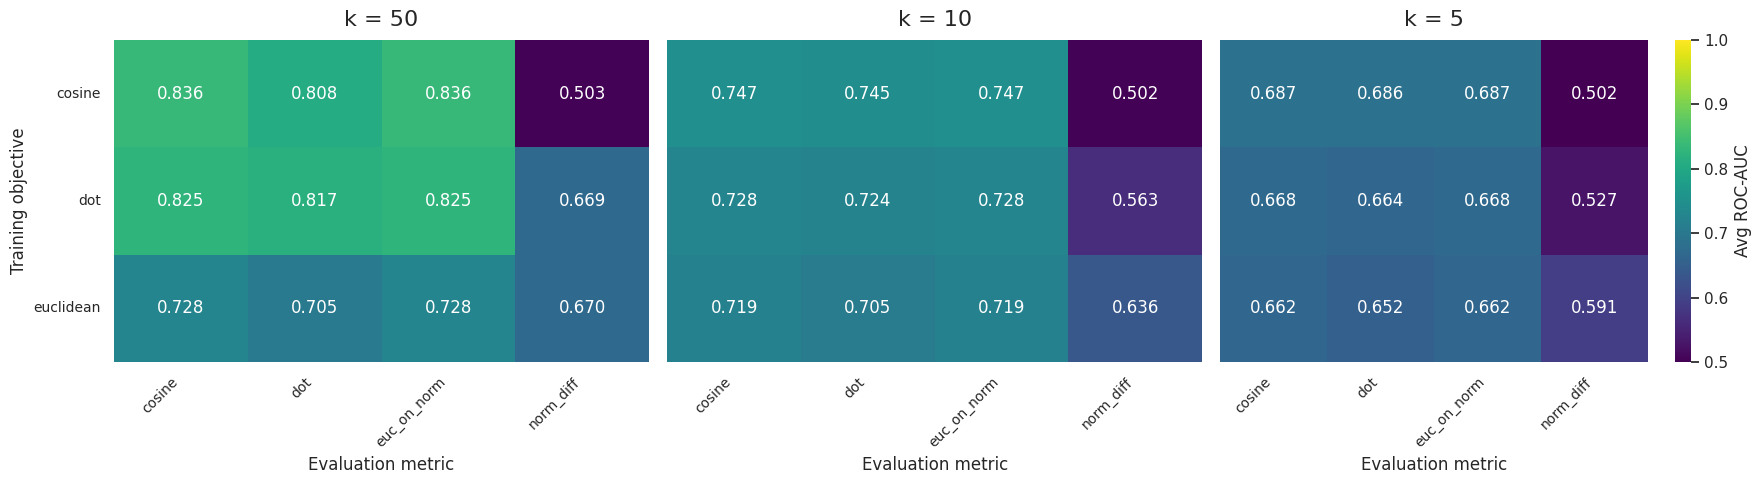

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume `dfs` is a dict mapping k-values to their aggregated DataFrame as provided:
# dfs = {5: agg_df_k5, 10: agg_df_k10, 50: agg_df_k50}

# First, compute the 'areas' DataFrame for each k, as before
areas_dict = {}
for k, agg in dfs.items():
    # Compute normalized area = average AUC across mu for each (trained_on, eval_metric)
    def avg_auc(group):
        mus = group['mu'].values
        aucs = group['mean'].values
        return np.trapz(aucs, mus) / (mus.max() - mus.min())
    
    areas = (
        agg
        .groupby(['trained_on','eval_metric'])
        .apply(avg_auc)
        .unstack('eval_metric')
    )
    areas_dict[k] = areas

# Determine global color scale
all_values = np.concatenate([areas.values.flatten() for areas in areas_dict.values()])
vmin, vmax = all_values.min(), all_values.max()

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, len(areas_dict), figsize=(18, 5), sharey=True)

for ax, (k, areas) in zip(axes, areas_dict.items()):
    # draw heatmap with explicit ticklabels
    sns.heatmap(
        areas,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        vmin=0.5, vmax=1.0,
        #vmin=vmin, vmax=vmax,
        cbar=ax is axes[-1],
        cbar_kws={'label': 'Avg ROC-AUC'} if ax is axes[-1] else None,
        yticklabels=True,           # force y‐ticks on every subplot
        xticklabels=True,
        ax=ax
    )
    # now override the y‐tick labels to be the DataFrame index
    ax.set_yticks(np.arange(len(areas.index)) + 0.5)
    ax.set_yticklabels(areas.index, rotation=0, fontsize=10)

    ax.set_title(f"k = {k}", fontsize=16, pad=10)
    ax.set_xlabel("Evaluation metric", fontsize=12)
    if ax is axes[0]:
        ax.set_ylabel("Training objective", fontsize=12)
    else:
        ax.set_ylabel("")

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)

plt.tight_layout()
plt.show()

Processing k=50: 100%|██████████████████████████████████████████████████████████████████████████| 57/57 [00:27<00:00,  2.10it/s]


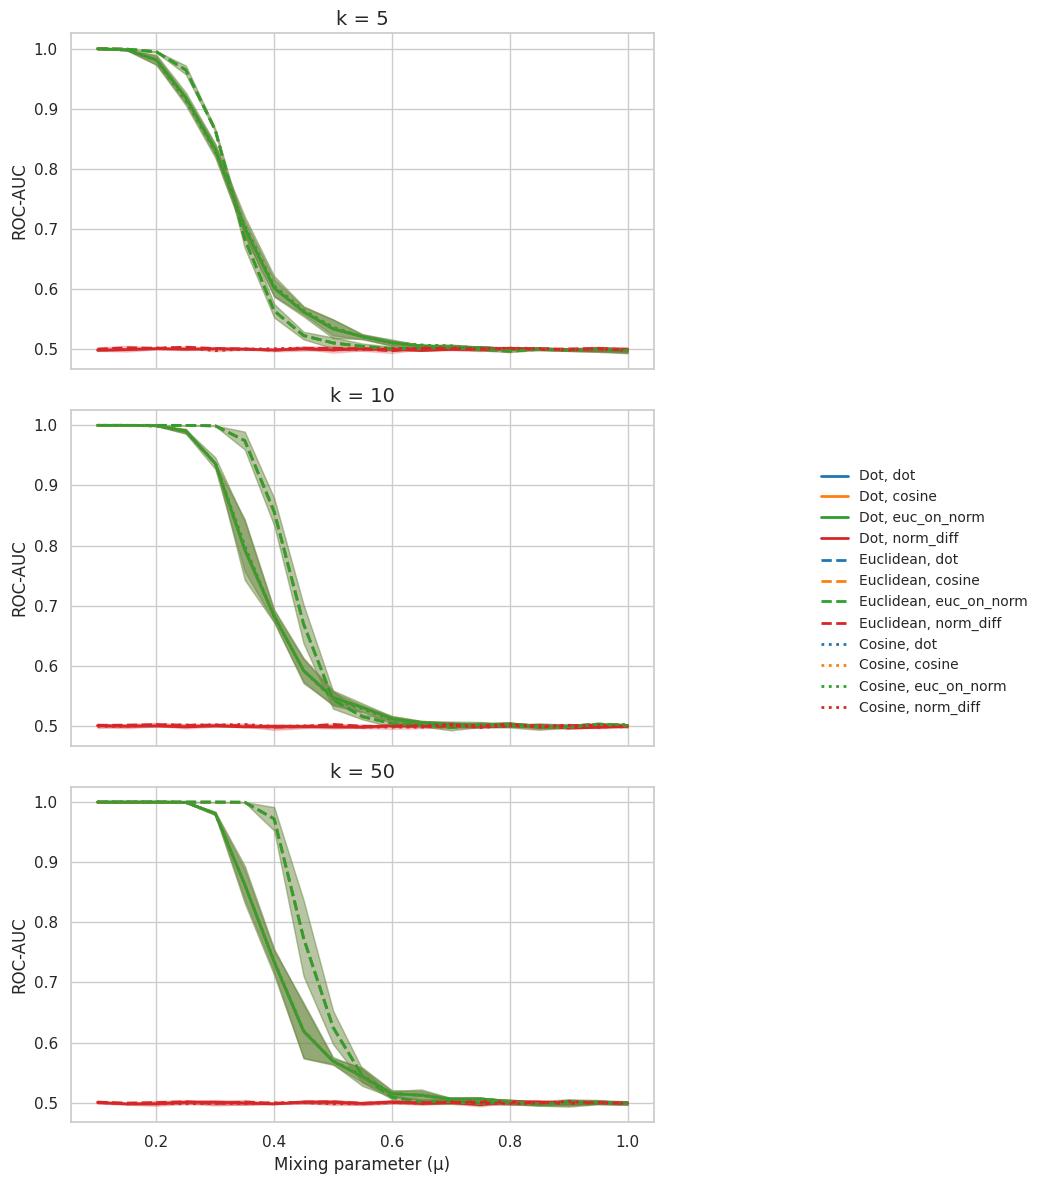

In [108]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import roc_auc_score
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# --- Helper functions ---

def sample_pairs(comm, n_pos=50000, n_neg=50000, seed=0):
    """Uniformly sample n_pos same-community and n_neg different-community pairs."""
    rng = np.random.default_rng(seed)
    N = len(comm)
    same, diff = [], []
    while len(same) < n_pos or len(diff) < n_neg:
        i, j = rng.integers(0, N, 2)
        if i == j: 
            continue
        if comm[i] == comm[j]:
            if len(same) < n_pos: same.append((i, j))
        else:
            if len(diff) < n_neg: diff.append((i, j))
    pairs = np.array(same + diff, dtype=int)
    labels = np.array([1]*len(same) + [0]*len(diff))
    return pairs, labels

def compute_scores_for_embedding(E, pairs):
    """Compute dot, cosine, norm_diff, and euc_on_norm for each pair."""
    i_idx, j_idx = pairs[:,0], pairs[:,1]
    dots = np.sum(E[i_idx] * E[j_idx], axis=1)
    norms = np.linalg.norm(E, axis=1)
    cosines = dots / (norms[i_idx] * norms[j_idx] + 1e-12)
    norm_diff = -np.abs(norms[i_idx] - norms[j_idx])
    E_unit = E / (norms[:, None] + 1e-12)
    euc_on_norm = -np.linalg.norm(E_unit[i_idx] - E_unit[j_idx], axis=1)
    return {'dot': dots, 'cosine': cosines, 'norm_diff': norm_diff, 'euc_on_norm': euc_on_norm}

def process_task(task):
    """Load embeddings and communities, sample pairs, compute AUC records."""
    mu, run, base_dir,file_dir, k = task
    mu_str = f"{mu}"
    run_dir = os.path.join(file_dir, f"Run_{run}")
    emb_dir = os.path.join(base_dir, f"Run_{run}")

    emb_path = os.path.join(
        emb_dir,
        f"embeddings_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu_str}_k_{k}_mincomm_50.pkl"
    )
    comm_path = os.path.join(
        run_dir,
        f"community_table_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu_str}_k_{k}_mincomm_50.csv"
    )
    # Load
    with open(emb_path, 'rb') as f:
        embeddings = pickle.load(f)
    comm = pd.read_csv(comm_path)['community_id'].values
    
    # Sample & score
    pairs, labels = sample_pairs(comm, seed=run)
    records = []
    for emb_name, E in embeddings.items():
        scores = compute_scores_for_embedding(E, pairs)
        for metric, sc in scores.items():
            auc = roc_auc_score(labels, sc)
            records.append({
                'k': k, 'mu': mu, 'run': run,
                'trained_on': emb_name,
                'eval_metric': metric,
                'auc': auc
            })
    return records

# --- Main processing loop over k values ---

mix_vals = [round(x, 2) for x in np.arange(0.1, 1.01, 0.05)]
runs = range(1, 4)
ks = [5, 10, 50]
max_workers = 32

all_records = []
for k in ks:
    base_dir = f'/l/research/gogandhi.NOBACKUP/alt_means_sans_k/data/experiment_n2v_metric_spherical_10000_{k}_3.0_minc50'
    file_dir = f'/l/research/gogandhi.NOBACKUP/alt_means_sans_k/data/experiment_n2v_metric_change_10000_{k}_3.0_minc50_immutable'
    tasks = [(mu, run, base_dir,file_dir, k) for mu in mix_vals for run in runs]
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_task, t): t for t in tasks}
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing k={k}"):
            all_records.extend(future.result())

# --- Aggregate into dfs dict ---

df_all = pd.DataFrame(all_records)
dfs_sph = {}
for k, grp in df_all.groupby('k'):
    agg = (
        grp.groupby(['mu', 'trained_on', 'eval_metric'])['auc']
           .agg(['mean', 'std'])
           .reset_index()
    )
    dfs_sph[k] = agg

# --- Plotting ---

sns.set(style='whitegrid')
palette = sns.color_palette("tab10", n_colors=4)
metric_colors = {'dot': palette[0], 'cosine': palette[1],
                 'euc_on_norm': palette[2], 'norm_diff': palette[3]}
trained_styles = {'dot': 'solid', 'euclidean': 'dashed', 'cosine': 'dotted'}

fig, axes = plt.subplots(len(ks), 1, figsize=(8, 4*len(ks)), sharex=True, sharey=True)
for ax, k in zip(axes, ks):
    agg = dfs_sph[k]
    for emb in ['dot', 'euclidean', 'cosine']:
        for metric, color in metric_colors.items():
            grp = agg[(agg['trained_on']==emb)&(agg['eval_metric']==metric)]
            if grp.empty: continue
            ax.plot(grp['mu'], grp['mean'],
                    label=f"{emb.capitalize()}, {metric}",
                    color=color, linestyle=trained_styles[emb], linewidth=2)
            ax.fill_between(grp['mu'], grp['mean']-grp['std'], grp['mean']+grp['std'],
                            color=color, alpha=0.2)
    ax.set_title(f"k = {k}", fontsize=14)
    ax.set_ylabel("ROC-AUC", fontsize=12)
axes[-1].set_xlabel("Mixing parameter (μ)", fontsize=12)

# Shared legend outside
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5),
           frameon=False, fontsize=10)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


In [101]:
dfs_sph

{5:       mu trained_on  eval_metric      mean       std
 0    0.1     cosine       cosine  0.999691  0.000046
 1    0.1     cosine          dot  0.999691  0.000046
 2    0.1     cosine  euc_on_norm  0.999691  0.000046
 3    0.1     cosine    norm_diff  0.498187  0.003682
 4    0.1        dot       cosine  0.999677  0.000055
 ..   ...        ...          ...       ...       ...
 223  1.0        dot    norm_diff  0.498992  0.005327
 224  1.0  euclidean       cosine  0.498946  0.003684
 225  1.0  euclidean          dot  0.498946  0.003684
 226  1.0  euclidean  euc_on_norm  0.498946  0.003684
 227  1.0  euclidean    norm_diff  0.498492  0.001680
 
 [228 rows x 5 columns],
 10:       mu trained_on  eval_metric      mean           std
 0    0.1     cosine       cosine  1.000000  2.886751e-09
 1    0.1     cosine          dot  1.000000  2.886751e-09
 2    0.1     cosine  euc_on_norm  1.000000  2.886751e-09
 3    0.1     cosine    norm_diff  0.498852  3.046311e-03
 4    0.1        dot       c

/tmp/ipykernel_4175289/3392199515.py:18: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_4175289/3392199515.py:18: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_4175289/3392199515.py:18: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operati

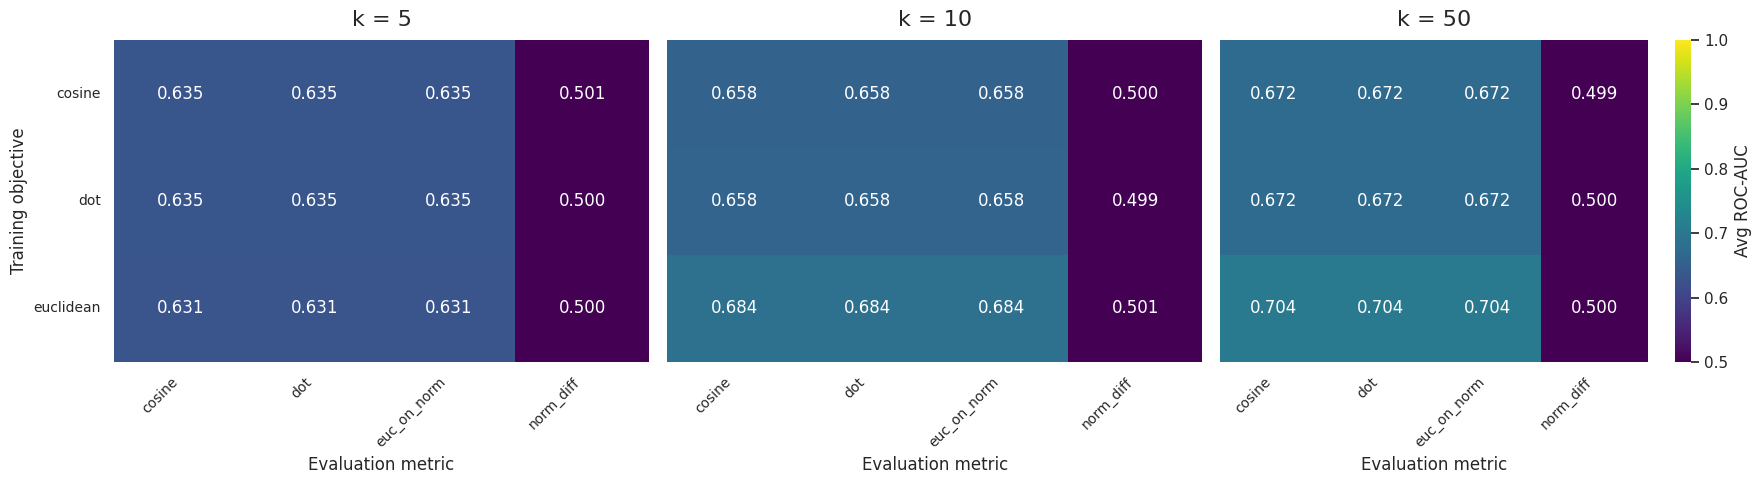

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume `dfs` is a dict mapping k-values to their aggregated DataFrame as provided:
# dfs = {5: agg_df_k5, 10: agg_df_k10, 50: agg_df_k50}

# First, compute the 'areas' DataFrame for each k, as before
areas_dict = {}
for k, agg in dfs_sph.items():
    # Compute normalized area = average AUC across mu for each (trained_on, eval_metric)
    def avg_auc(group):
        mus = group['mu'].values
        aucs = group['mean'].values
        return np.trapz(aucs, mus) / (mus.max() - mus.min())
    
    areas = (
        agg
        .groupby(['trained_on','eval_metric'])
        .apply(avg_auc)
        .unstack('eval_metric')
    )
    areas_dict[k] = areas

# Determine global color scale
all_values = np.concatenate([areas.values.flatten() for areas in areas_dict.values()])
vmin, vmax = all_values.min(), all_values.max()

# areas_dict: { k: DataFrame(rows=trained_on, cols=eval_metric) }

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, len(areas_dict), figsize=(18, 5), sharey=True)

for ax, (k, areas) in zip(axes, areas_dict.items()):
    # draw heatmap with explicit ticklabels
    sns.heatmap(
        areas,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        vmin=0.5, vmax=1.0,
        #vmin=vmin, vmax=vmax,
        cbar=ax is axes[-1],
        cbar_kws={'label': 'Avg ROC-AUC'} if ax is axes[-1] else None,
        yticklabels=True,           # force y‐ticks on every subplot
        xticklabels=True,
        ax=ax
    )
    # now override the y‐tick labels to be the DataFrame index
    ax.set_yticks(np.arange(len(areas.index)) + 0.5)
    ax.set_yticklabels(areas.index, rotation=0, fontsize=10)

    ax.set_title(f"k = {k}", fontsize=16, pad=10)
    ax.set_xlabel("Evaluation metric", fontsize=12)
    if ax is axes[0]:
        ax.set_ylabel("Training objective", fontsize=12)
    else:
        ax.set_ylabel("")

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)

plt.tight_layout()
plt.show()


Interactive plot for comparing both unconstrained and spherically constrained embeddings

In [116]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1) Your k‐values and data dicts
ks = [5, 10, 50]
# dfs    = { k: agg_df_for_unconstrained }
# dfs_sph= { k: agg_df_for_spherical   }

# 2) Styling
metric_colors  = {'dot':'yellow','cosine':'blue','euc_on_norm':'green','norm_diff':'red'}
trained_styles = {'dot':'solid','euclidean':'dash','cosine':'dot'}

# 3) Build interleaved subplot_titles: row1→(k5 normal, k5 sph), row2→(k10 normal, k10 sph), ...
titles = []
for k in ks:
    titles.append(f"k={k} (normal)")
    titles.append(f"k={k} (spherical)")

fig = make_subplots(
    rows=3, cols=2,
    shared_xaxes=True, shared_yaxes=True,
    horizontal_spacing=0.1, vertical_spacing=0.05,
    subplot_titles=titles
)

# 4) Plot each row k, each col (0→dfs, 1→dfs_sph)
shown = set()
for row_idx, k in enumerate(ks, start=1):
    for col_idx, data_dict in enumerate([dfs, dfs_sph], start=1):
        agg = data_dict[k]
        for emb in ['dot','euclidean','cosine']:
            for metric, color in metric_colors.items():
                combo = f"{emb}-{metric}"
                grp = agg[(agg['trained_on']==emb)&(agg['eval_metric']==metric)]
                if grp.empty:
                    continue
                show_legend = combo not in shown
                shown.add(combo)
                # main line
                fig.add_trace(
                    go.Scatter(
                        x=grp['mu'], y=grp['mean'],
                        mode='lines',
                        name=combo,
                        legendgroup=combo,
                        showlegend=show_legend,
                        line=dict(color=color, dash=trained_styles[emb], width=2)
                    ),
                    row=row_idx, col=col_idx
                )
                # shaded ±1 std
                fig.add_trace(
                    go.Scatter(
                        x=list(grp['mu']) + grp['mu'][::-1].tolist(),
                        y=list(grp['mean']+grp['std']) + (grp['mean']-grp['std'])[::-1].tolist(),
                        fill='toself',
                        fillcolor=color,
                        opacity=0.2,
                        line=dict(color='rgba(0,0,0,0)'),
                        hoverinfo='skip',
                        showlegend=False,
                        legendgroup=combo
                    ),
                    row=row_idx, col=col_idx
                )

# 5) Axes labels
for r in range(1, 4):
    fig.update_xaxes(title_text="Mixing μ", row=r, col=1)
    fig.update_xaxes(title_text="Mixing μ", row=r, col=2)
    fig.update_yaxes(title_text="ROC-AUC", row=r, col=1)

# 6) Layout & export
fig.update_layout(
    height=1200, width=1000,
    title_text="Community AUC vs μ: Normal (L) vs Spherical (R)",
    legend=dict(x=1.02, y=0.5, bgcolor='rgba(255,255,255,0)', bordercolor='black'),
    hovermode="x unified"
)

output_path = "community_auc_compare.html"
fig.write_html(output_path, include_plotlyjs="cdn")
print(f"Saved interactive plot to: {output_path}")


Saved interactive plot to: community_auc_compare.html


## Dot similarity has very little length information in it.

Cosine and Euc_on_norm having higher AUC and norm_diff having lower is implying angular info is

In [ ]:
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score

# --- Assume you already have:
# E          : (N×d) numpy array of embeddings (e.g. dot‐trained model)
# pairs, labels : from sample_pairs(comm, ...)

# Example: regenerate pairs & labels for context
# pairs, labels = sample_pairs(comm, n_pos=20000, n_neg=20000, seed=0)

# Now unpack i/j indices
i_idx = pairs[:, 0]
j_idx = pairs[:, 1]

# 1) Compute norms
norms = np.linalg.norm(E_dot, axis=1)
print("Mean norm:", norms.mean(), "Std norm:", norms.std())

# 2) Raw dot‐product scores
scores_dot = np.sum(E_dot[i_idx] * E_dot[j_idx], axis=1)

# 3) Cosine scores
scores_cos = scores_dot / (norms[i_idx] * norms[j_idx] + 1e-12)

# 4) Spearman rank correlation
rho, pval = spearmanr(scores_dot, scores_cos)
print(f"Spearman ρ between dot and cosine: {rho:.4f} (p={pval:.2e})")

# 5) AUCs
auc_dot = roc_auc_score(labels, scores_dot)
auc_cos = roc_auc_score(labels, scores_cos)
print(f"AUC(dot):   {auc_dot:.4f}")
print(f"AUC(cosine):{auc_cos:.4f}")

Mean norm: 1.3751396 Std norm: 0.1641878
Spearman ρ between dot and cosine: 0.9761 (p=0.00e+00)
AUC(dot):   0.9998
AUC(cosine):1.0000


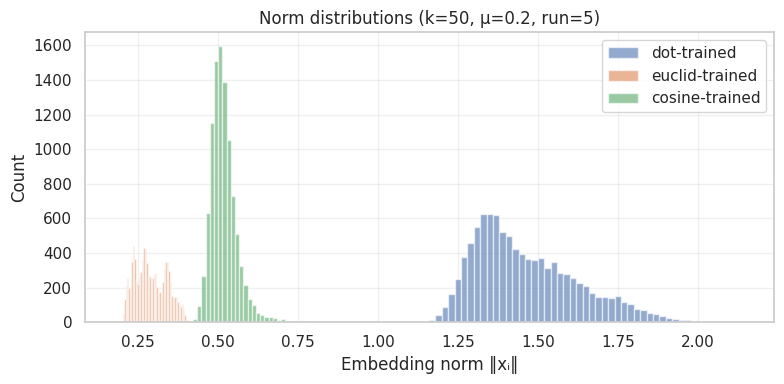

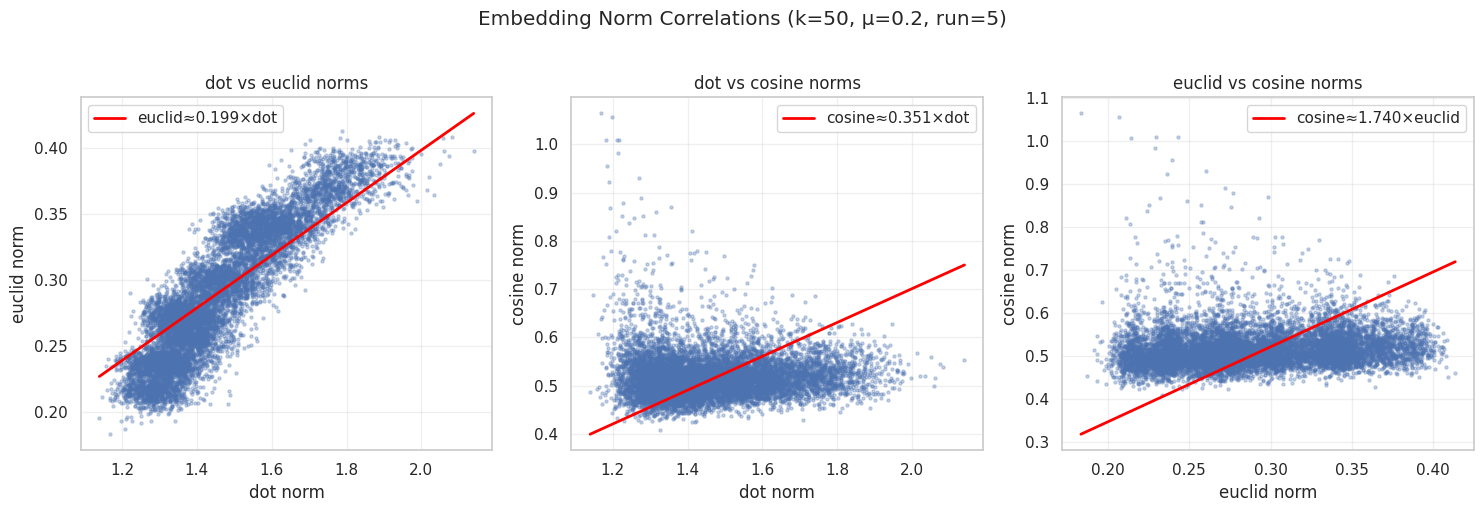

In [128]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# --- Parameters: pick one k, mu, and run instance ---
k   = 50
mu  = 0.20
run = 5

# --- Paths: adjust base_dir if needed ---
base_dir = (
    f"/l/research/gogandhi.NOBACKUP/"
    f"alt_means_sans_k/data/experiment_n2v_metric_change_10000_{k}_3.0_minc50_immutable"
)
run_dir = os.path.join(base_dir, f"Run_{run}")
mu_str  = f"{mu}"

emb_path = os.path.join(
    run_dir,
    f"embeddings_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu_str}_k_{k}_mincomm_50.pkl"
)

# --- Load all three embeddings ---
with open(emb_path, "rb") as f:
    embeddings = pickle.load(f)
E_dot   = embeddings["dot"]
E_euc   = embeddings["euclidean"]
E_cos   = embeddings["cosine"]

# --- Compute norms ---
norms = {
    "dot":   np.linalg.norm(E_dot, axis=1),
    "euclid":np.linalg.norm(E_euc, axis=1),
    "cosine":np.linalg.norm(E_cos, axis=1),
}

# --- 1) Histogram of norms for all three ---
plt.figure(figsize=(8, 4))
bins = 50
alpha = 0.6
plt.hist(norms["dot"],    bins=bins, alpha=alpha, label="dot-trained")
plt.hist(norms["euclid"], bins=bins, alpha=alpha, label="euclid-trained")
plt.hist(norms["cosine"], bins=bins, alpha=alpha, label="cosine-trained")
plt.xlabel("Embedding norm ‖xᵢ‖")
plt.ylabel("Count")
plt.title(f"Norm distributions (k={k}, μ={mu_str}, run={run})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 2) Pairwise scatter + regression of norms ---
pairs = [("dot", "euclid"), ("dot", "cosine"), ("euclid", "cosine")]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (n1, n2) in zip(axes, pairs):
    x = norms[n1]
    y = norms[n2]
    # Fit line y ≈ m*x
    model = LinearRegression(fit_intercept=False)
    model.fit(x.reshape(-1, 1), y)
    m = model.coef_[0]
    # Plot
    ax.scatter(x, y, s=5, alpha=0.3)
    x_line = np.linspace(x.min(), x.max(), 200)
    ax.plot(x_line, m * x_line, color="red", lw=2,
            label=f"{n2}≈{m:.3f}×{n1}")
    ax.set_xlabel(f"{n1} norm")
    ax.set_ylabel(f"{n2} norm")
    ax.set_title(f"{n1} vs {n2} norms")
    ax.legend()
    ax.grid(alpha=0.3)

fig.suptitle(f"Embedding Norm Correlations (k={k}, μ={mu_str}, run={run})", y=1.02)
plt.tight_layout()
plt.show()


In [138]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import roc_auc_score
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# --- Helper functions ---

def sample_pairs(comm, n_pos=50000, n_neg=50000, seed=0):
    rng = np.random.default_rng(seed)
    N = len(comm)
    same, diff = [], []
    while len(same) < n_pos or len(diff) < n_neg:
        i, j = rng.integers(0, N, 2)
        if i == j:
            continue
        if comm[i] == comm[j]:
            if len(same) < n_pos:
                same.append((i, j))
        else:
            if len(diff) < n_neg:
                diff.append((i, j))
    pairs = np.array(same + diff, dtype=int)
    labels = np.array([1]*len(same) + [0]*len(diff))
    return pairs, labels

def compute_scores_for_embedding(E, pairs):
    i_idx, j_idx = pairs[:,0], pairs[:,1]
    dots = np.sum(E[i_idx] * E[j_idx], axis=1)
    norms = np.linalg.norm(E, axis=1)
    cosines = dots / (norms[i_idx] * norms[j_idx] + 1e-12)
    norm_diff = -np.abs(norms[i_idx] - norms[j_idx])
    E_unit = E / (norms[:, None] + 1e-12)
    euc_on_norm = -np.linalg.norm(E_unit[i_idx] - E_unit[j_idx], axis=1)
    return {'dot': dots, 'cosine': cosines, 'norm_diff': norm_diff, 'euc_on_norm': euc_on_norm}

def process_task(task):
    """Load embeddings and communities, sample pairs, compute AUC for raw and normed embeddings."""
    mu, run, base_dir, k = task
    mu_str = f"{mu}"
    run_dir = os.path.join(base_dir, f"Run_{run}")
    emb_path = os.path.join(run_dir,
        f"embeddings_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu_str}_k_{k}_mincomm_50.pkl")
    comm_path = os.path.join(run_dir,
        f"community_table_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu_str}_k_{k}_mincomm_50.csv")
    
    if not os.path.exists(emb_path) or not os.path.exists(comm_path):
        return []
    
    # Load
    with open(emb_path, 'rb') as f:
        embeddings = pickle.load(f)
    comm = pd.read_csv(comm_path)['community_id'].values
    
    # Create unit-normalized versions for each embedding type
    for emb_name in list(embeddings.keys()):
        E = embeddings[emb_name]
        norms = np.linalg.norm(E, axis=1, keepdims=True)
        embeddings[f"{emb_name}_normed"] = E / (norms + 1e-12)
    
    # Sample & score
    pairs, labels = sample_pairs(comm, seed=run)
    records = []
    for emb_name, E in embeddings.items():
        scores = compute_scores_for_embedding(E, pairs)
        for metric, sc in scores.items():
            auc = roc_auc_score(labels, sc)
            records.append({
                'k': k,
                'mu': mu,
                'run': run,
                'trained_on': emb_name,
                'eval_metric': metric,
                'auc': auc
            })
    return records

# --- Main loop over k values, parallelized ---

mix_vals = [round(x, 2) for x in np.arange(0.05, 1.01, 0.05)]
runs = range(1, 11)
ks = [5, 10, 50]
max_workers = 32

all_records = []
for k in ks:
    base_dir = (
        f"/l/research/gogandhi.NOBACKUP/alt_means_sans_k/data/"
        f"experiment_n2v_metric_change_10000_{k}_3.0_minc50_immutable"
    )
    tasks = [(mu, run, base_dir, k) for mu in mix_vals for run in runs]
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        for recs in tqdm(executor.map(process_task, tasks), total=len(tasks), desc=f"Processing k={k}"):
            all_records.extend(recs)

# --- Aggregate normalized embeddings AUCs into dfs_norm ---

df_all = pd.DataFrame(all_records)
dfs_norm = {}
# filter for any trained_on ending with '_normed'
df_normed = df_all[df_all['trained_on'].str.endswith('_normed')]
for k, grp in df_normed.groupby('k'):
    agg = (
        grp.groupby(['mu','trained_on','eval_metric'])['auc']
           .agg(['mean','std'])
           .reset_index()
    )
    dfs_norm[k] = agg

print("dfs_norm computed for normalized embeddings:", dfs_norm.keys())


Processing k=50: 100%|████████████████████████████████████████████████████████████████████████| 200/200 [01:18<00:00,  2.55it/s]

dfs_norm computed for normalized embeddings: dict_keys([5, 10, 50])


In [150]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ks and your three dfs dicts must be defined:
# ks = [5, 10, 50]
# dfs      = {k: agg_df_unconstrained}
# dfs_norm = {k: agg_df_normalized_embeddings}
# dfs_sph  = {k: agg_df_spherical_embeddings}

# Define colors & dash styles for evaluation metrics
metric_colors = {'dot':'blue', 'cosine':'green', 'euc_on_norm':'red', 'norm_diff':'orange'}
trained_styles = {'dot':'solid','euclidean':'dash','cosine':'dot'}

# Scenarios: (column label, data dict, list of trained_on keys)
scenarios = [
    ("Unconstrained", dfs, ['dot','euclidean','cosine']),
    ("Normalized",    dfs_norm, ['dot_normed','euclidean_normed','cosine_normed']),
    ("Spherical",     dfs_sph, ['dot','euclidean','cosine'])
]

# Build 3x3 subplot grid with titles
subplot_titles = []
for k in ks:
    for scen_label, _, _ in scenarios:
        subplot_titles.append(f"k={k}  {scen_label}")

fig = make_subplots(
    rows=len(ks), cols=3,
    shared_xaxes=True, shared_yaxes=True,
    horizontal_spacing=0.05, vertical_spacing=0.07,
    subplot_titles=subplot_titles
)

shown = set()
for row_idx, k in enumerate(ks, start=1):
    for col_idx, (_label, data_dict, emb_keys) in enumerate(scenarios, start=1):
        agg = data_dict[k]
        for emb_key in emb_keys:
            # derive base name for legend (remove '_normed' suffix)
            base = emb_key.replace('_normed','')
            for metric in ['dot','cosine','euc_on_norm','norm_diff']:
                grp = agg[(agg['trained_on']==emb_key) & (agg['eval_metric']==metric)]
                if grp.empty:
                    continue
                combo = f"{base}-{metric}"
                show_legend = combo not in shown
                shown.add(combo)
                # main line
                fig.add_trace(
                    go.Scatter(
                        x=grp['mu'], y=grp['mean'],
                        mode='lines',
                        name=combo,
                        legendgroup=combo,
                        showlegend=show_legend,
                        line=dict(color=metric_colors[metric],
                                  dash=trained_styles[base],
                                  width=2)
                    ),
                    row=row_idx, col=col_idx
                )
                # shaded ±1 std band
                fig.add_trace(
                    go.Scatter(
                        x=list(grp['mu']) + grp['mu'][::-1].tolist(),
                        y=list(grp['mean']+grp['std']) + (grp['mean']-grp['std'])[::-1].tolist(),
                        fill='toself',
                        fillcolor=metric_colors[metric],
                        opacity=0.2,
                        line=dict(color='rgba(0,0,0,0)'),
                        showlegend=False,
                        legendgroup=combo
                    ),
                    row=row_idx, col=col_idx
                )

# Set axis labels
for r in range(1, len(ks)+1):
    for c in range(1, 4):
        fig.update_xaxes(title_text="μ", row=r, col=c)
    fig.update_yaxes(title_text="ROC-AUC", row=r, col=1)

# Layout and save
fig.update_layout(
    height=1200, width=1200,
    title_text="AUC vs μ across Unconstrained, Normalized, and Spherical Embeddings",
    legend=dict(x=1.02, y=0.5),
    hovermode="x unified"
)

fig.write_html("compare_three.html", include_plotlyjs="cdn")
print("Saved interactive plot to compare_three.html")


Exception: The (row, col) pair sent is out of range. Use Figure.print_grid to view the subplot grid. 

In [151]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- assume dfs and dfs_sph are defined: {k: agg_df}, agg_df has columns
#     ['mu','trained_on','eval_metric','mean','std']

ks = [5, 10, 50]
scenarios = [
    ("Unconstrained", dfs),
    ("Spherical",     dfs_sph)
]

# color for each eval_metric
metric_colors = {
    'dot':        'blue',
    'cosine':     'green',
    'euc_on_norm':'red',
    'norm_diff':  'orange'
}

# create 3×1 column
fig = make_subplots(
    rows=len(ks), cols=1,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    subplot_titles=[f"k = {k}" for k in ks]
)

shown = set()
for i, k in enumerate(ks, start=1):
    for scenario, data_dict in scenarios:
        agg = data_dict[k]
        for emb in ['dot','euclidean','cosine']:
            for metric, color in metric_colors.items():
                dfm = agg[
                    (agg['trained_on']==emb) &
                    (agg['eval_metric']==metric)
                ]
                if dfm.empty:
                    continue

                label = f"{scenario}–{emb}–{metric}"
                showleg = label not in shown
                shown.add(label)

                # main line
                fig.add_trace(
                    go.Scatter(
                        x=dfm['mu'], y=dfm['mean'],
                        mode='lines',
                        name=label,
                        legendgroup=label,
                        showlegend=showleg,
                        line=dict(
                            color=color,
                            dash='solid' if scenario=="Unconstrained" else 'dash',
                            width=2
                        )
                    ),
                    row=i, col=1
                )
                # shaded band
                upper = dfm['mean'] + dfm['std']
                lower = dfm['mean'] - dfm['std']
                fig.add_trace(
                    go.Scatter(
                        x=list(dfm['mu']) + dfm['mu'][::-1].tolist(),
                        y=list(upper) + list(lower[::-1]),
                        fill='toself',
                        fillcolor=color,
                        opacity=0.2,
                        line=dict(color='rgba(0,0,0,0)'),
                        hoverinfo='skip',
                        showlegend=False,
                        legendgroup=label
                    ),
                    row=i, col=1
                )

    # axes titles
    fig.update_xaxes(title_text="Mixing μ", row=i, col=1)
    fig.update_yaxes(title_text="ROC-AUC", row=i, col=1)

fig.update_layout(
    height=300*len(ks), width=700,
    title_text="Community AUC vs μ: Unconstrained (solid) vs Spherical (dashed)",
    legend=dict(x=1.02, y=0.5),
    hovermode="x unified"
)

# save to HTML
fig.write_html("unconstrained_vs_spherical.html", include_plotlyjs="cdn")
print("Saved interactive plot to unconstrained_vs_spherical.html")


Saved interactive plot to unconstrained_vs_spherical.html
